# Predict ligand profiling using `kissim` using the Davis dataset

In order to assess the predictive power of `kissim`, we here choose a ligand-centric evaluation. 
We will compare if `kissim` can predict on- and off-targets determined in ligand profiling studies.

- Kinase-kinase distance dataset (use KinMap kinase names): Select kinases from profiling dataset by query ligand
- Kinase-ligand profiling dataset (use KinMap kinase names and PKIDB ligand names): Select kinases from distances dataset by the ligand's on-target
- Merge both datasets and keep only kinases that have measurements in both datasets
- Rank kinases by distances
- Calculuate enrichment factors and enrichment plots
- Calculate ROC curves

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from src import data, evaluation

In [3]:
plt.style.use("seaborn")

## Define parameters

In [4]:
# The only global that can be changed in this notebook
LIGAND_PROFILING_METHOD = "davis"

In [5]:
KINASE_DISTANCES_METHOD = "kissim"
KINASE_ACTIVITY_CUTOFF = 100
KINASE_ACTIVITY_MAX = True
MIN_N_SHARED_KINASES = 10
MIN_N_SHARED_ACTIVE_KINASES = 3

## Kinase-kinase distances dataset

__Criteria__: 

- Filters out kinases whose names cannot be mapped to KinMap kinase names.

In [6]:
# Full dataset (reported only, not further used)
kissim_df = data.distances.kissim(kinmap_kinases=False)
print(f"Kinase distance matrix shape: {kissim_df.shape}")

Kinase distance matrix shape: (257, 257)


In [7]:
# Reduced dataset
kissim_df = data.distances.kissim(kinmap_kinases=True)
print(f"Kinase distance matrix shape: {kissim_df.shape}")
kissim_df.iloc[:5, :5]

Changed kinase names (unknown names may be discarded - see function docstring):
    kinase.input            kinase.kinmap
68         DCLK1                  DCAMKL1
120       JAK1-b                   JAK1_b
156       MSK1-b                   MSK1_b
175       PI4K2A  unknown (not in KinMap)
176        PI4KB  unknown (not in KinMap)
177       PIK3C3  unknown (not in KinMap)
206       RSK2-b                   RSK2_b
207       RSK3-b                   RSK3_b
232       TYK2-b                   TYK2_b
249        p110a  unknown (not in KinMap)
250        p110d  unknown (not in KinMap)
251        p110g  unknown (not in KinMap)


Kinase distance matrix shape: (251, 251)


,AAK1,ABL1,ABL2,ACK,ACTR2
AAK1,0.000000,0.107122,0.111726,0.108950,0.110255
ABL1,0.107122,0.000000,0.011441,0.066001,0.115258
ABL2,0.111726,0.011441,0.000000,0.066760,0.121243
ACK,0.108950,0.066001,0.066760,0.000000,0.121621
ACTR2,0.110255,0.115258,0.121243,0.121621,0.000000


## Kinase-ligand profiling dataset

__Criteria__:

- Load dataset with FDA-approved PKIDB ligands only.
- Filters out ligands whose names cannot be mapped onto PKIDB ligand names.

In [8]:
# Full dataset (reported only, not further used)
profiling_df = data.profiling.load(LIGAND_PROFILING_METHOD)
print(f"Number of kinases (full dataset): {profiling_df.shape[0]}")
print(f"Number of ligands (full dataset): {profiling_df.shape[1]}")

Number of kinases (full dataset): 350
Number of ligands (full dataset): 72


In [9]:
# Reduced dataset
profiling_df = data.profiling.load(LIGAND_PROFILING_METHOD, pkidb_ligands=True, fda_approved=False)
print(f"Number of kinases (FDA-approved PKIDB ligands only): {profiling_df.shape[0]}")
print(f"Number of ligands (FDA-approved PKIDB ligands only): {profiling_df.shape[1]}")
profiling_df.head()

Changed ligand names (unknown names may be discarded - see function docstring):
         ligand.input            ligand.pkidb
0           TG-101348              Fedratinib
1           SB-203580  unknown (not in PKIDB)
3    CHIR-265/RAF-265  unknown (not in PKIDB)
4        AZD-1152HQPA  unknown (not in PKIDB)
5            MLN-8054  unknown (not in PKIDB)
..                ...                     ...
67          LY-333531           Ruboxistaurin
68            CI-1033              Canertinib
69  AZD-6244/ARRY-886  unknown (not in PKIDB)
70             PI-103  unknown (not in PKIDB)
71           AZD-2171               Cediranib

[61 rows x 2 columns]


Number of kinases (FDA-approved PKIDB ligands only): 350
Number of ligands (FDA-approved PKIDB ligands only): 34


,Fedratinib,Nilotinib,Axitinib,Midostaurin,Quizartinib,Linifanib,Neratinib,Masitinib,Brivanib,Vatalanib,...,Tandutinib,Sunitinib,Alvocidib,Erlotinib,Imatinib,Bosutinib,Afatinib,Ruboxistaurin,Canertinib,Cediranib
AAK1,35.0,NaN,1200.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.0,5300.0,1200.0,NaN,2300.000,NaN,900.0,NaN,NaN
ABL1,44.0,13.0,36.0,NaN,NaN,NaN,NaN,55.0,640.0,NaN,...,NaN,150.0,1500.0,76.0,21.0,0.057,570.0,NaN,30.0,78.0
ABL2,570.0,26.0,70.0,NaN,NaN,NaN,NaN,110.0,1800.0,NaN,...,NaN,1000.0,NaN,200.0,10.0,1.500,NaN,NaN,870.0,730.0
ALK2,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2500.0,NaN,1900.0,NaN,NaN,NaN,NaN,NaN,1700.0,3400.0
ALK4,6700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.0


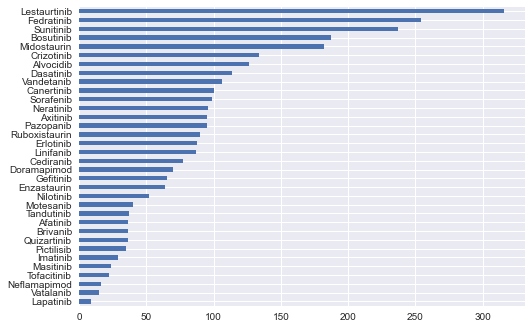

In [10]:
profiling_df.count().sort_values().plot(kind="barh");

### Ligands' on-targets dataset

__Criteria__: 

- Filters out ligands that are not available in the PKIDB or have no targets in the PKIDB.
- Filters out targets whose names cannot be mapped onto KinMap names

In [11]:
pd.set_option("max_colwidth", 100)
ligand_names = profiling_df.columns
ligand_targets = data.targets.pkidb(ligand_names, fda_approved=False)
ligand_targets

Changed kinase names (unknown names may be discarded - see function docstring):
    kinase.input            kinase.kinmap
8            nan  unknown (not in KinMap)
10         CSF1R                      FMS
13         CSF1R                      FMS
15         ERBB2                    ErbB2
18        PDGFRA                   PDGFRa
19        PDGFRB                   PDGFRb
37        PDGFRA                   PDGFRa
38        PDGFRB                   PDGFRb
41        MAPK14                     p38a
43         ERBB2                    ErbB2
46         EPHA2                    EphA2
48          YES1                      YES
50        PDGFRB                   PDGFRb
53           nan  unknown (not in KinMap)
54        MAPK14                     p38a
55         VEGFA  unknown (not in KinMap)
57          PTK6                      BRK
58           TEK                     TIE2
65        PDGFRB                   PDGFRb
74        PDGFRA                   PDGFRa
75        PDGFRB                   PDG

,ligand.input,targets.pkidb,targets.kinmap
15,Afatinib,"[EGFR, ERBB2, ERBB4]","[EGFR, ErbB2, ErbB4]"
17,Axitinib,"[FLT1, KDR, FLT4]","[FLT1, KDR, FLT4]"
27,Bosutinib,"[BCR, ABL1, LYN, HCK, SRC, CDK2, MAP2K1, MAP2K2, MAP3K2, CAMK2G]","[BCR, ABL1, LYN, HCK, SRC, CDK2, MAP2K1, MAP2K2, MAP3K2, CaMK2g]"
2,Brivanib,[KDR],[KDR]
3,Canertinib,[EGFR],[EGFR]
4,Cediranib,[KDR],[KDR]
9,Crizotinib,"[ALK, MET]","[ALK, MET]"
25,Dasatinib,"[ABL1, SRC, EPHA2, LCK, YES1, KIT, PDGFRB, ABL2, FYN]","[ABL1, SRC, EphA2, LCK, YES, KIT, PDGFRb, ABL2, FYN]"
5,Doramapimod,[MAPK14],[p38a]
6,Erlotinib,[EGFR],[EGFR]


### Ligand-kinase datasets

We merge now profiling and kinase similarity information into one dataset per ligand-kinase pair (_ligand-kinase dataset_). 

We only keep ligand-kinase pairs that
- have a minimum of `MIN_N_SHARED_KINASES` shared kinases
- have a minimum of `MIN_N_SHARED_ACTIVE_KINASES` shared active kinases, while activity is defined <= `KINASE_ACTIVITY_CUTOFF`

Select ligand-kinase pairs with enough coverage.

In [12]:
ligand_kinase_pairs = (
    ligand_targets[["ligand.input", "targets.kinmap"]]
    .explode("targets.kinmap")
    .to_numpy()
    .tolist()
)

## Evaluation metrics

In [13]:
evaluator = evaluation.LigandVsKinaseEvaluator(
    ligand_kinase_pairs,
    LIGAND_PROFILING_METHOD,
    KINASE_DISTANCES_METHOD,
    KINASE_ACTIVITY_CUTOFF,
    KINASE_ACTIVITY_MAX,
    MIN_N_SHARED_KINASES,
    MIN_N_SHARED_ACTIVE_KINASES,
    kinmap_kinases=False,
)

Changed ligand names (unknown names may be discarded - see function docstring):
         ligand.input            ligand.pkidb
0           TG-101348              Fedratinib
1           SB-203580  unknown (not in PKIDB)
3    CHIR-265/RAF-265  unknown (not in PKIDB)
4        AZD-1152HQPA  unknown (not in PKIDB)
5            MLN-8054  unknown (not in PKIDB)
..                ...                     ...
67          LY-333531           Ruboxistaurin
68            CI-1033              Canertinib
69  AZD-6244/ARRY-886  unknown (not in PKIDB)
70             PI-103  unknown (not in PKIDB)
71           AZD-2171               Cediranib

[61 rows x 2 columns]
ERROR:root:'Query kinase FLT1 is not part of kinase-kinase matrix.'
ERROR:root:'Query kinase FLT4 is not part of kinase-kinase matrix.'
ERROR:root:'Query kinase BCR is not part of kinase-kinase matrix.'
ERROR:root:'CDK2 is not part of the ligand profiling dataset for Bosutinib'
ERROR:root:'Query kinase MAP2K2 is not part of kinase-kinase matri

In [14]:
pkidb = data.ligands.pkidb()
ligands = pkidb.set_index("ID")["Type"][list(evaluator.data_dict.keys())].reset_index()
ligands

,ID,Type
0,Afatinib,1
1,Axitinib,2
2,Bosutinib,1
3,Brivanib,nan
4,Canertinib,nan
5,Cediranib,nan
6,Crizotinib,1
7,Dasatinib,1
8,Doramapimod,2
9,Erlotinib,1.5


### Enrichment

#### Enrichment factor 

An enrichment factor is calculated as follows:

$EF_{x\%} = \frac{\frac{n_s}{n}}{\frac{N_s}{N}}$

with

- $N$   : Number of kinases in total
- $N_s$ : Number of kinases in top x% of ranked kinases
- $n$   : Number of active kinases in total
- $n_s$ : Number of active kinases in top x% of ranked kinases

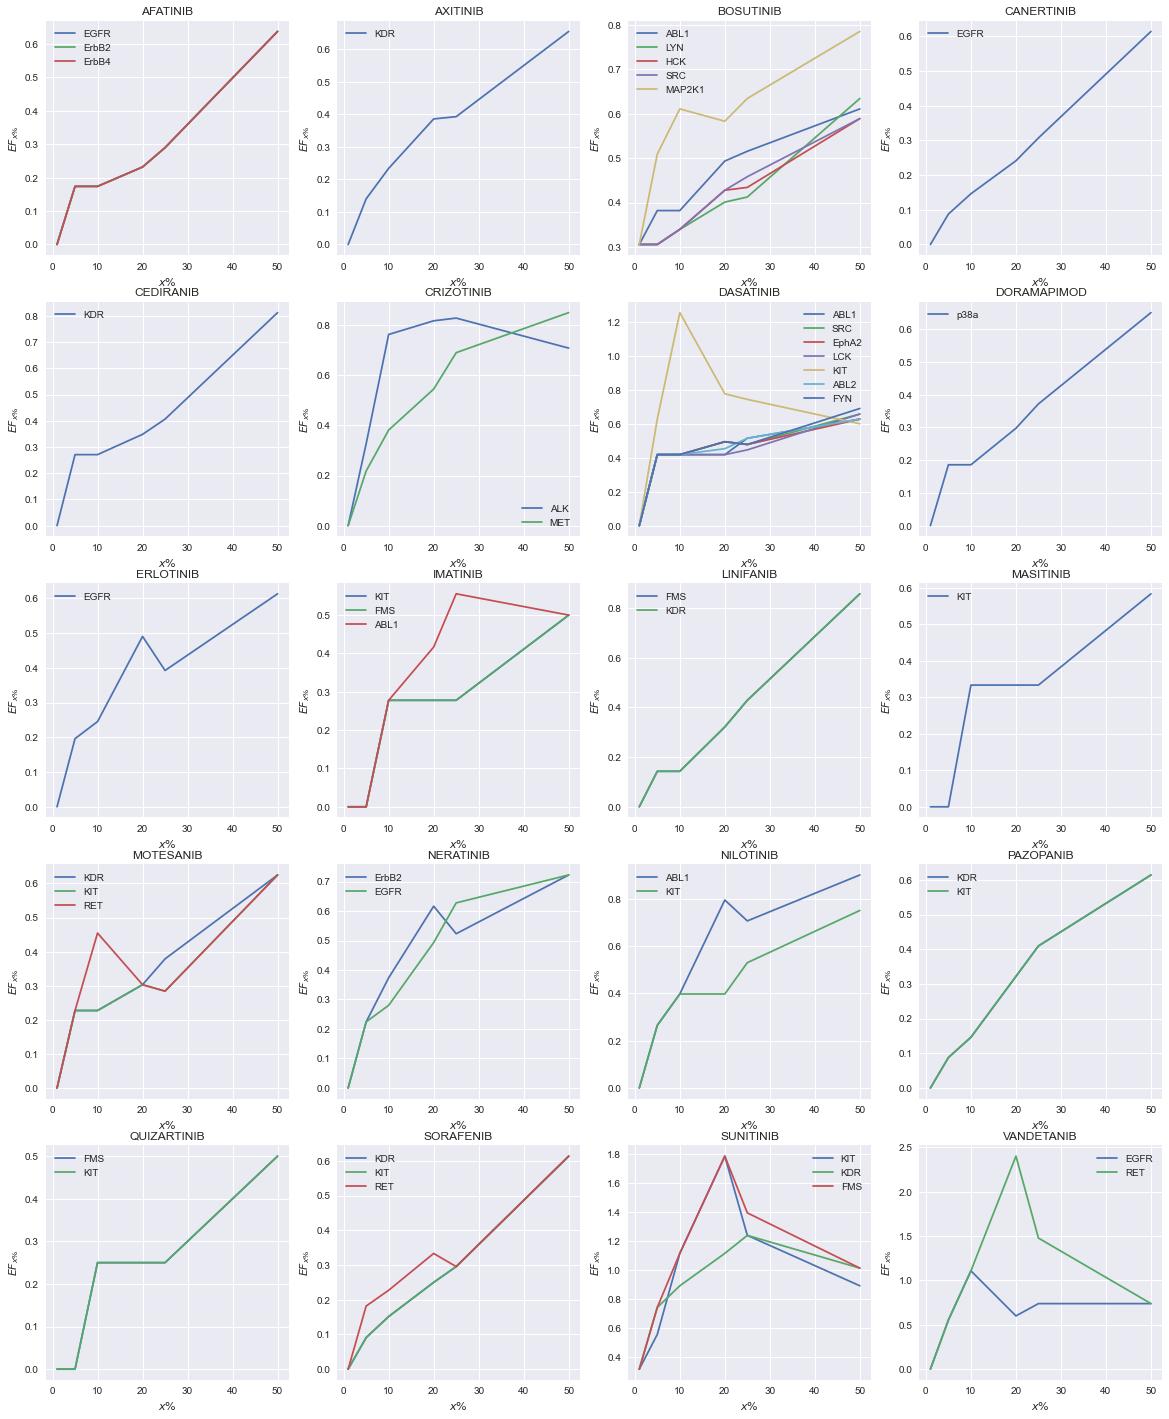

In [15]:
evaluator.plot_enrichment_factors()

#### Enrichment plots

For an enrichment plot, the x and y values are calculated as follows:

$x = \frac{N_s}{N}$, $y = \frac{n_s}{n}$

with

- $N$   : Number of kinases in total
- $N_s$ : Number of kinases in top x% of ranked kinases
- $n$   : Number of active kinases in total
- $n_s$ : Number of active kinases in top x% of ranked kinases

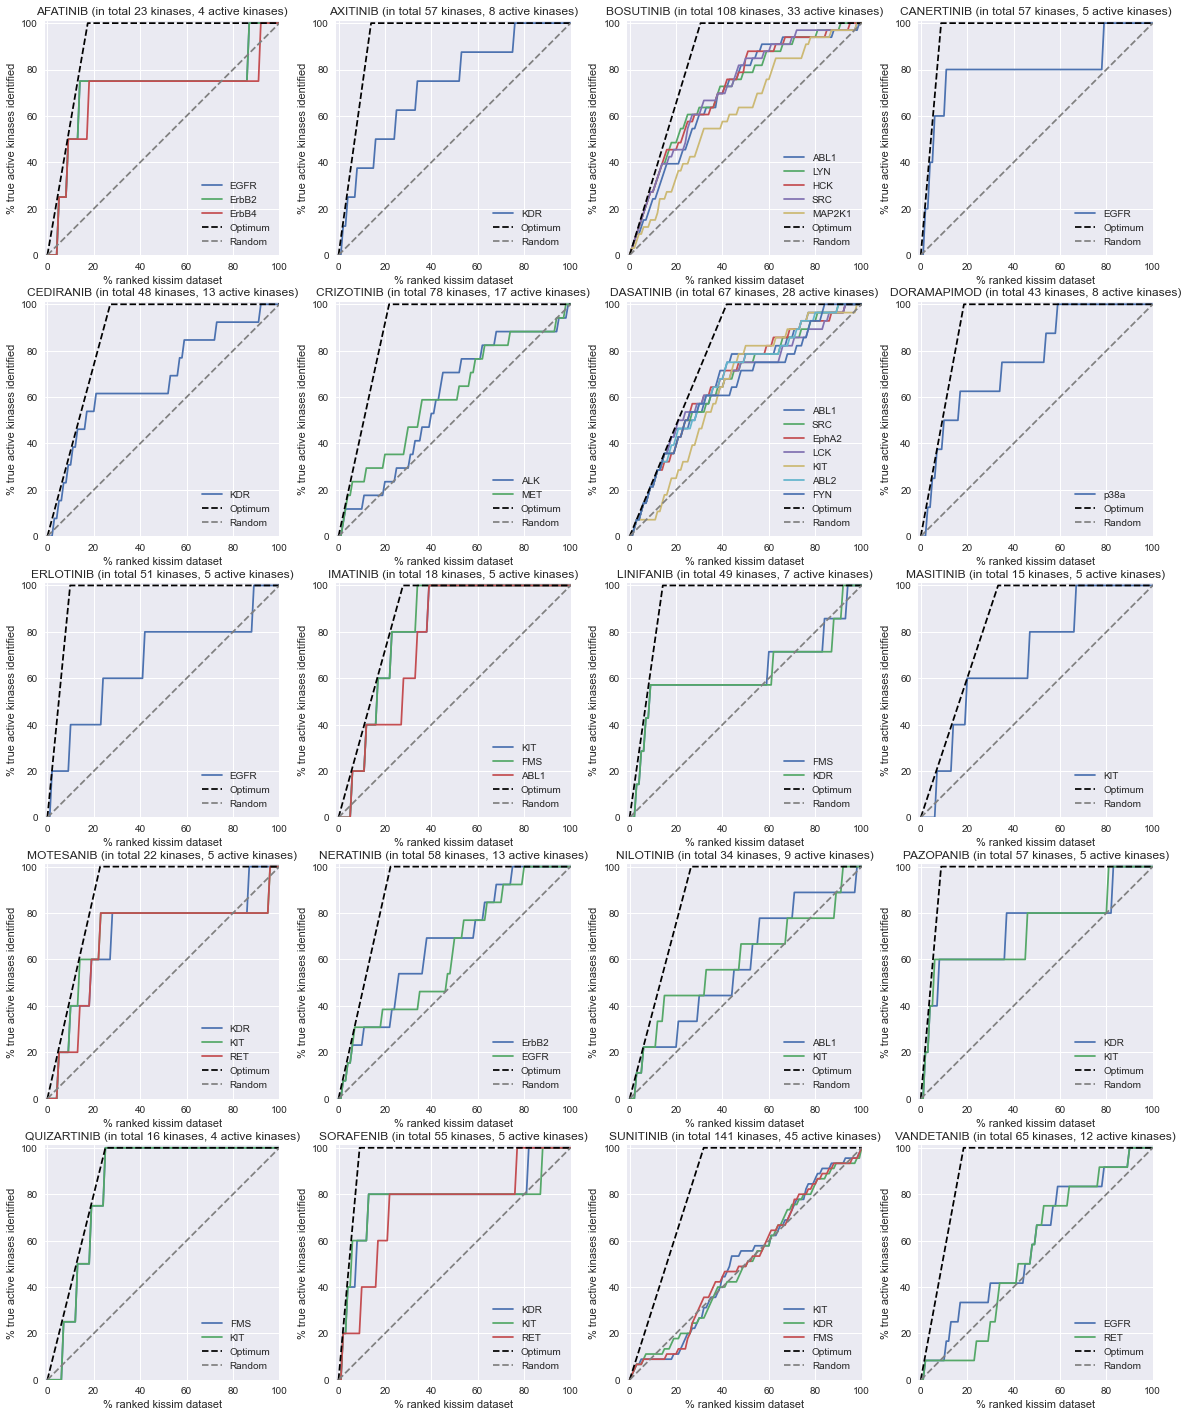

In [16]:
evaluator.plot_enrichment()

### ROC curves

- $TPR = \frac{TP}{P} = \frac{TP}{TP + FN}$
- $FPR = \frac{FP}{N} = \frac{FP}{FP + TN}$

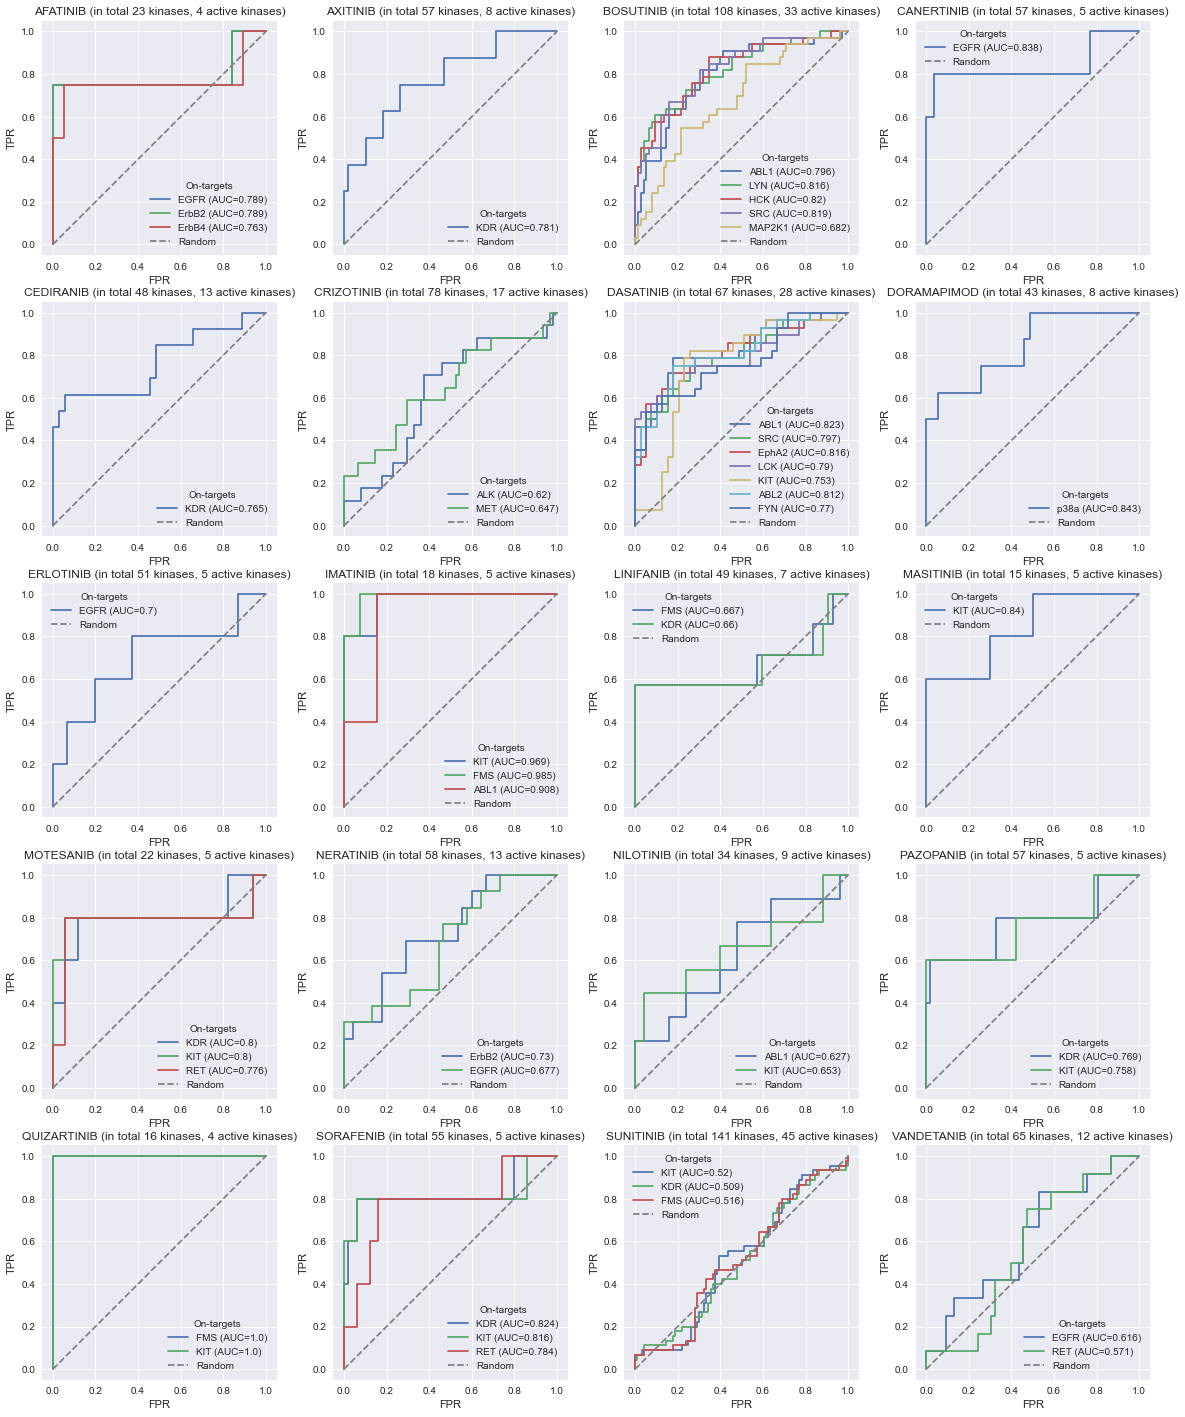

In [17]:
evaluator.plot_roc_curves();